In [1]:
# Importações

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
np.random.seed(0)

In [2]:
# Leitura de arquivos

testOriginal = pd.read_csv("Arquivos csv/test.csv")
trainOriginal = pd.read_csv("Arquivos csv/train.csv")

In [3]:
# Funções

def valoresFalta(df):
    """Essa função é responsável por tratar dos valores em falta do dataframe passado como argumento"""
    df['Age'] = df['Age'].fillna(df['Age'].median())

    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    df = df.drop(["Ticket", "Cabin"], axis = 1)
    
    return df

def ordinalEncoding(df):
    """Essa função realiza o one-hot encode e, como saída, retorna um novo dataframe
    com as colunas que resultam da codificação, devidamente nomeadas, ao invés
    de features categóricas"""
    dfCopia = df
    OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(dfCopia[object_cols]))
    OH_cols.index = df.index
    OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)
    dfCopia = dfCopia.drop(object_cols, axis = 1)
    OH_X = pd.concat([dfCopia, OH_cols], axis=1)
    return OH_X

# Função para calcular o MI Scores 
def make_mi_scores(X, y, discrete_features):
    """Função responsável por calcular o MI Scores"""
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

# Função para plotar o gráfico de MI Scores
def plot_mi_scores(scores):
    """Função responsável por plotar o gráfico de MI Scores"""
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# Separando os títulos de cada passageiro de seu nome
def title(df):
    """Esta função identifica e separa o título de cada passageiro"""
    titles = df["Name"].str.split(", ", expand = True)
    df["Title"] = titles[1]
    titles = df["Title"].str.split(".", expand = True)
    df["Title"] = titles[0]
    df = df.drop(["Name"], axis = 1)
    return df

# Criar feature que indique o tamanho da família, somando "SibSp" e "Parch"
def familySize(df):
    """Essa função calcula o tamanho da família de cada passageiro e verifica se ele está sozinha"""
    components = ["SibSp", "Parch"]
    df["FamilySize"] = df[components].gt(0).sum(axis = 1)
    alone = []
    for i in df.index:
        if df["FamilySize"][i] == 0:
            alone.append(True)
        else:
            alone.append(False)
    df["Alone"] = alone
    return df

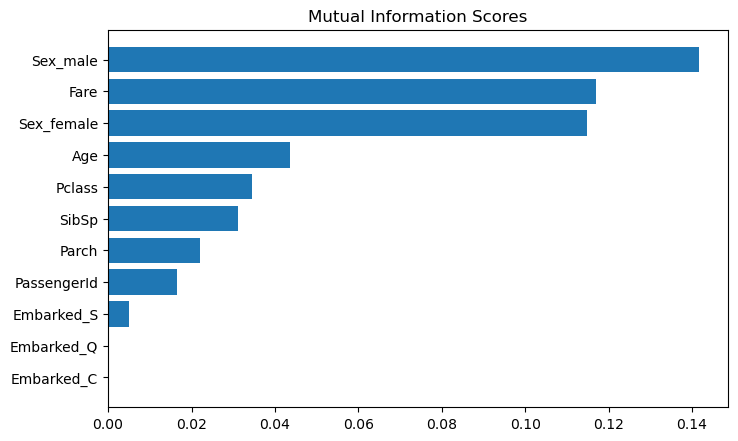

In [4]:
# Exercícios 9.1 - Nº 01

# Tratando valores em falta
test = valoresFalta(testOriginal)
train = valoresFalta(trainOriginal)
object_cols = list(train.drop(["Name"], axis = 1).select_dtypes(
    include = object).columns)

train2 = ordinalEncoding(train).drop(["Name"], axis = 1)
test2 = ordinalEncoding(test).drop(["Name"], axis = 1)

# Determinar as features discretas
discrete_features = train2.drop(["Survived"], axis = 1).dtypes == int

# Determinando as features e o target
X = train2.drop(['Survived'], axis=1)
y = train2["Survived"]

# Produzir o gráfico
mi_scores = make_mi_scores(X, y, discrete_features)    
plt.figure(dpi = 100, figsize = (8, 5))
plot_mi_scores(mi_scores)

In [5]:
# Exercício 9.2 - Nº 01
train3 = ordinalEncoding(train)
test3 = ordinalEncoding(test)

train3 = title(train3)
test3 = title(test3)
print(train3.head())

   PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  \
0            1         0       3  22.0      1      0   7.2500         0.0   
1            2         1       1  38.0      1      0  71.2833         1.0   
2            3         1       3  26.0      0      0   7.9250         1.0   
3            4         1       1  35.0      1      0  53.1000         1.0   
4            5         0       3  35.0      0      0   8.0500         0.0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S Title  
0       1.0         0.0         0.0         1.0    Mr  
1       0.0         1.0         0.0         0.0   Mrs  
2       0.0         0.0         0.0         1.0  Miss  
3       0.0         0.0         0.0         1.0   Mrs  
4       1.0         0.0         0.0         1.0    Mr  


In [6]:
# Exercício 9.2 - Nº 02

train3 = familySize(train3)
test3 = familySize(test3)

print(train3.head())

   PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  \
0            1         0       3  22.0      1      0   7.2500         0.0   
1            2         1       1  38.0      1      0  71.2833         1.0   
2            3         1       3  26.0      0      0   7.9250         1.0   
3            4         1       1  35.0      1      0  53.1000         1.0   
4            5         0       3  35.0      0      0   8.0500         0.0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S Title  FamilySize  Alone  
0       1.0         0.0         0.0         1.0    Mr           1  False  
1       0.0         1.0         0.0         0.0   Mrs           1  False  
2       0.0         0.0         0.0         1.0  Miss           0   True  
3       0.0         0.0         0.0         1.0   Mrs           1  False  
4       1.0         0.0         0.0         1.0    Mr           0   True  


<AxesSubplot:title={'center':"Chance média de sobrevivência de cada grupo do 'Fare_age'"}, xlabel='Fare_age', ylabel='Survived'>

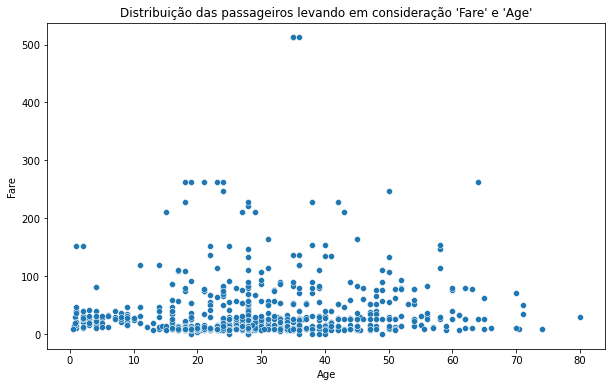

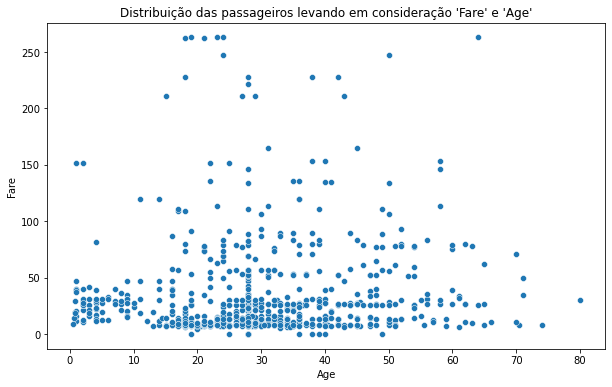

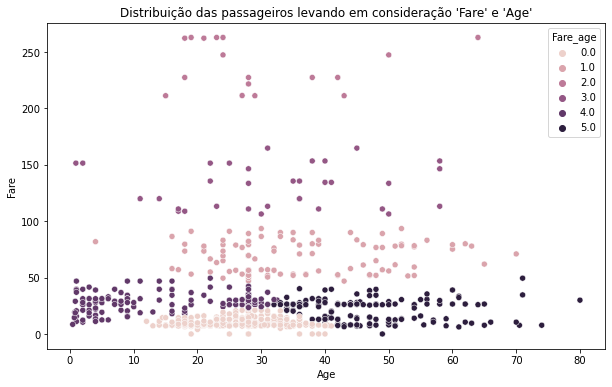

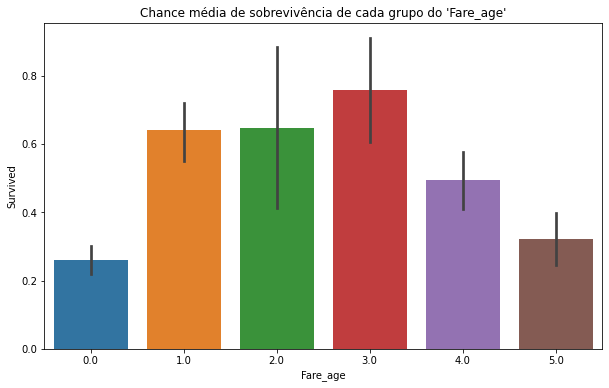

In [7]:
# Exercício 9.3 - Nº 01
train4 = ordinalEncoding(train)
test4 = ordinalEncoding(test)

# Gráfico colocando "Age" e "Fare" como eixos
plt.figure(figsize = (10,6)) # Definindo tamanho da figura
plt.title("Distribuição das passageiros levando em consideração 'Fare' e 'Age'") # Add título
sns.scatterplot(x = "Age", y = "Fare", data = train4)

# Identificando e retirando outliers
t = train4.loc[train4["Fare"] > 500]
train4 = train4.drop(t.index)
train4 = train4[["Age", "Fare", "Survived"]]
plt.figure(figsize = (10,6)) # Definindo tamanho da figura
plt.title("Distribuição das passageiros levando em consideração 'Fare' e 'Age'") # Add título
sns.scatterplot(x = "Age", y = "Fare", data = train4)

# Algoritmo k-means
kmeans = KMeans(n_clusters = 6)
train4["Fare_age"] = kmeans.fit_predict(train4)
train4["Fare_age"] = train4["Fare_age"].astype("int")

train["Fare_age"] = train4["Fare_age"]

# Gráfico da distribuição "Fare" x "Age", tendos os grupos como camadas
plt.figure(figsize = (10,6)) # Definindo tamanho da figura
plt.title("Distribuição das passageiros levando em consideração 'Fare' e 'Age'") # Add título
sns.scatterplot(x = "Age", y = "Fare", hue = "Fare_age", data = train)

# Gráfico que indica a chance de sobrevivência, em média, de cada grupo
plt.figure(figsize = (10,6)) # Definindo tamanho da figura
plt.title("Chance média de sobrevivência de cada grupo do 'Fare_age'") # Add título
sns.barplot(x = 'Fare_age', y = 'Survived', data = train)

In [8]:
# Exercício 9.3 - Nº 02
# Identificando e substituindo os valores NaN
train["Fare_age"].loc[train["Fare_age"].isnull()] = 5

print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch     Fare Embarked  Fare_age  
0      0   7.2500        S       0.0  
1      0  71.2833        C       1.0  
2      0   7.9250        S       0.0  
3      0  53.1000        S       1.0  
4      0   8.0500        S       0.0  


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14720\3837837929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Fare_age"].loc[train["Fare_age"].isnull()] = 5


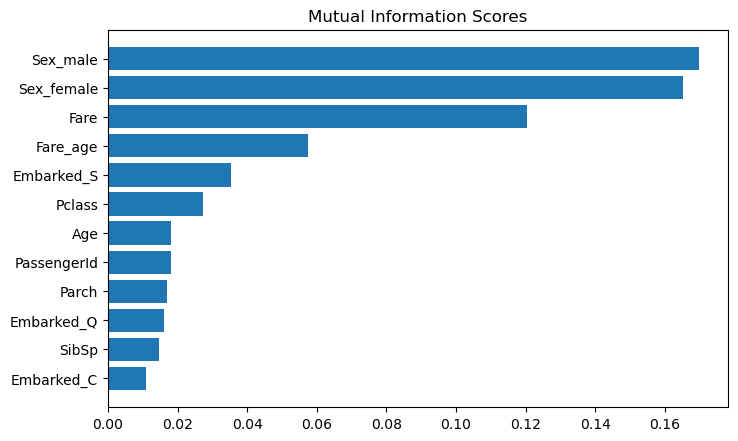

In [9]:
# Exercício 9.3 - Nº 03
# Avaliando, utilizando mutual information
train = ordinalEncoding(train).drop(["Name"], axis = 1)
test = ordinalEncoding(test).drop(["Name"], axis = 1)

# Determinar as features discretas
discrete_features = train.drop(["Survived"], axis = 1).dtypes == int

# Determinando as features e o target
X = train.drop(['Survived'], axis=1)
y = train["Survived"]

# Produzir o gráfico
mi_scores = make_mi_scores(X, y, discrete_features)    
plt.figure(dpi = 100, figsize = (8, 5))
plot_mi_scores(mi_scores)

<AxesSubplot:title={'center':"Histograma do scaling da feature 'Fare'"}, xlabel='Fare', ylabel='Count'>

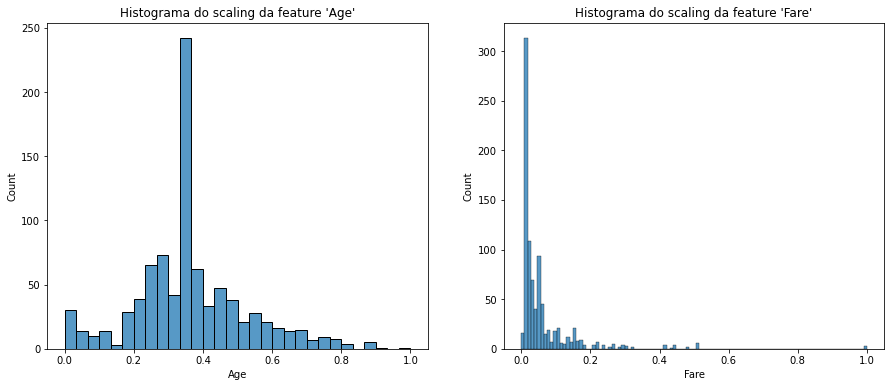

In [10]:
# Exercício 9.3 - Nº 04
# Scaling das features "Age" e "Fare", entre 0 e 1
scaler = MinMaxScaler(copy = False)
X_Scaler = pd.DataFrame()
for features in ['Fare', 'Age']:
    X_Scaler[[features]] = train[[features]]
    X_Scaler[[features]] = scaler.fit_transform(X_Scaler[[features]])
    
fig, eixos = plt.subplots(1, 2, figsize = (15, 6))

eixos[0].set_title("Histograma do scaling da feature 'Age'")
sns.histplot(x = "Age", data = X_Scaler, ax = eixos[0])

eixos[1].set_title("Histograma do scaling da feature 'Fare'")
sns.histplot(x = "Fare", data = X_Scaler, ax = eixos[1])

           PC1       PC2
Fare  0.087375  0.996175
Age   0.996175 -0.087375


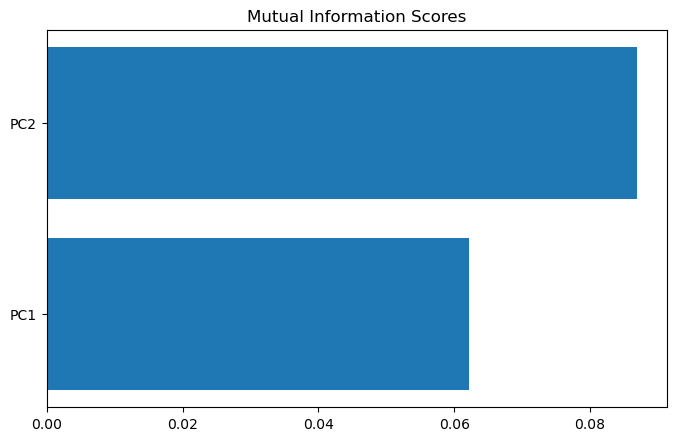

In [11]:
# Exercício 9.3 - Nº 05
pca = PCA()
X_pca = pca.fit_transform(X_Scaler)
component_name = [f"PC{i + 1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns = component_name)

loadings = pd.DataFrame(pca.components_.T, columns = component_name, index = X_Scaler.columns)

print(loadings)

# Determinar as features discretas
discrete_features = X_pca.dtypes == int

# Determinando as features e o target
y = train["Survived"]

# Produzir o gráfico
mi_scores = make_mi_scores(X_pca, y, discrete_features)    
plt.figure(dpi = 100, figsize = (8, 5))
plot_mi_scores(mi_scores)


É viável, com essas técnicas, a substituição das features 'Fare' e 'Age' por apenas uma? 
R: Não, pois o regplot de PC1 e PC2 não convergem nos quadrados mínimos lineares


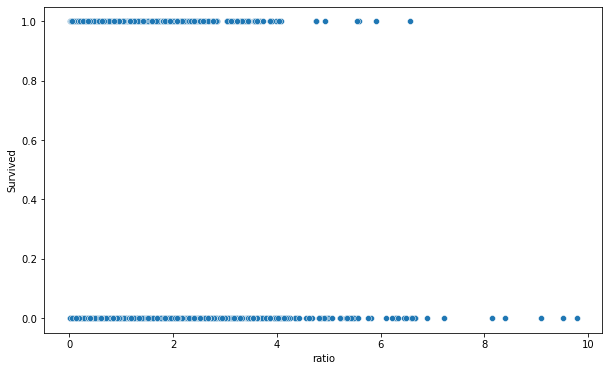

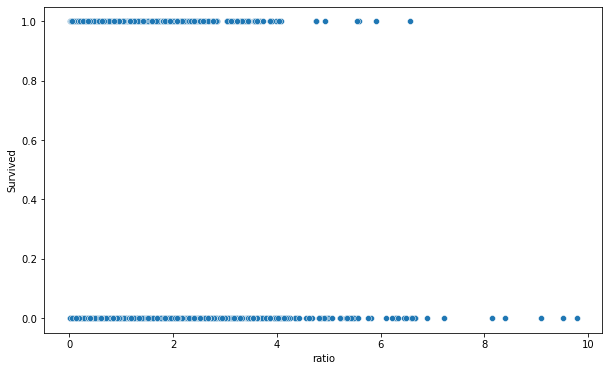

In [12]:
# Exercício 9.3 - Nº 06
# Mostrar o dataframe ordenado por PC1
idx = X_pca["PC1"].sort_values(ascending = False).index
cols = ["Fare", "Age"]
train["ratio"] = train["Age"] / train ["Fare"]
plt.figure(figsize = (10,6)) # Definindo tamanho da figura
sns.scatterplot(x = "ratio", y = "Survived", data = train)

# Mostrar o dataframe ordenado por PC2
idx = X_pca["PC2"].sort_values(ascending = False).index
cols = ["Fare", "Age"]
train["ratio"] = train["Age"] / train ["Fare"]
plt.figure(figsize = (10,6)) # Definindo tamanho da figura
sns.scatterplot(x = "ratio", y = "Survived", data = train)

train = train.drop(["ratio"], axis = 1)

print("\nÉ viável, com essas técnicas, a substituição das features 'Fare' e 'Age' por apenas uma? \nR: Não, pois o regplot de PC1 e PC2 não convergem nos quadrados mínimos lineares")

c:\Users\SAMSUNG\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


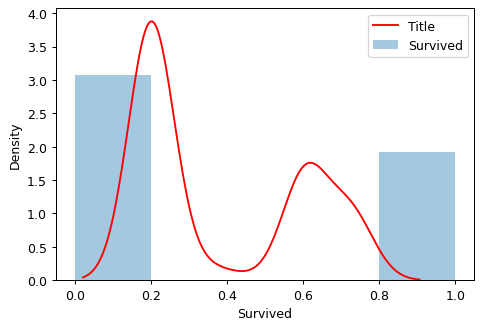

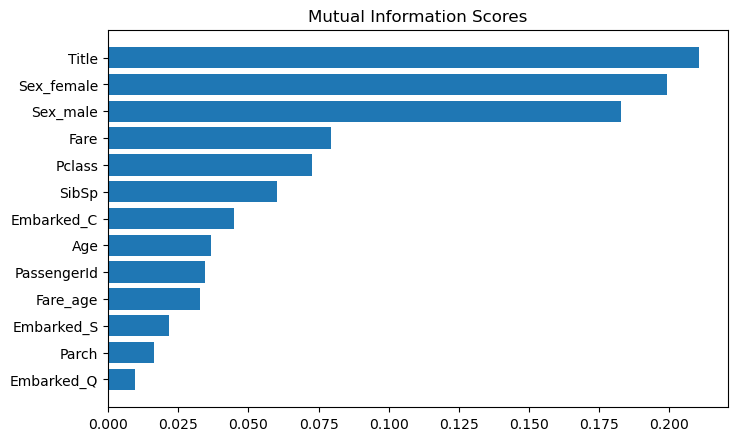

In [13]:
# Exercício 9.4
train["Title"] = train3["Title"]

X = train.copy()
y = X.pop("Survived")

X_encode = X.sample(frac = 0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

encoder = MEstimateEncoder(cols = ["Title"], m = 5.0)
encoder.fit(X_encode, y_encode)
X_train = encoder.transform(X_pretrain)

plt.figure(dpi = 90)
ax = sns.distplot(y, kde = False, norm_hist = True)
ax = sns.kdeplot(X_train["Title"], color = 'r', ax = ax)
ax.set_label("Survived")
ax.legend(labels = ['Title', 'Survived'])

# Determinar as features discretas
discrete_features = X_train.dtypes == int

# Produzir o gráfico
mi_scores = make_mi_scores(X_train, y_train, discrete_features)    
plt.figure(dpi = 100, figsize = (8, 5))
plot_mi_scores(mi_scores)